In [1]:
import numpy as np


In [20]:
class PcaAutoencoder:
    def __init__(self, n_components):
        self.n_components = n_components  # Number of principal components
        self.mean = None  # Mean of the data for centering
        self.eigenvectors = None  # Eigenvectors for the transformation
    
    def fit(self, X):
        """
        Fits the PCA model by calculating eigenvalues and eigenvectors.
        """
        # Step 1: Center the data by subtracting the mean
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Step 2: Compute the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)

        # Step 3: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Step 4: Sort eigenvectors by descending eigenvalues
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvectors = eigenvectors[:, sorted_indices[:self.n_components]]

    def encode(self, X):
        """
        Reduces the dimensionality of the input data using learned eigenvectors.
        """
        # Center the data
        X_centered = X - self.mean
        # Project onto the top principal components
        return np.dot(X_centered, self.eigenvectors)

    def forward(self, X):
        """
        Reconstructs the data from the reduced representation.
        """
        # Encode the data (reduce dimensionality)
        Z = self.encode(X)
        mean = np.mean(X, axis=0)
        # convert mean to 2D array
        mean = np.array([mean])
        # Reconstruct the data by projecting back to the original space
        X_reconstructed = np.dot(Z, self.eigenvectors.T) + mean
        return X_reconstructed


In [3]:
import pandas as pd

data_test = pd.read_csv("../../data/interim/fashion_mnist/fashion-mnist_test.csv")
data_train = pd.read_csv("../../data/interim/fashion_mnist/fashion-mnist_train.csv")

data = pd.concat([data_train, data_test], ignore_index=True)

# Extract labels and pixel data
labels = data['label']
pixels = data.drop(columns=['label'])


# Normalize pixel values
pixels = pixels / 255.0

# shuffle data
np.random.seed(42)
idx = np.random.permutation(len(pixels))
pixels = pixels.iloc[idx]
labels = labels.iloc[idx]

# test train val 20 70 10
X_train = pixels.iloc[:int(0.7*len(pixels))]
y_train = labels.iloc[:int(0.7*len(pixels))]
X_test = pixels.iloc[int(0.7*len(pixels)):int(0.9*len(pixels))]
y_test = labels.iloc[int(0.7*len(pixels)):int(0.9*len(pixels))]
X_val = pixels.iloc[int(0.9*len(pixels)):]
y_val = labels.iloc[int(0.9*len(pixels)):]

# # reshape to 28x28
# X_train = X_train.values.reshape(-1, 1, 28, 28)
# X_test = X_test.values.reshape(-1, 1, 28, 28)
# X_val = X_val.values.reshape(-1, 1, 28, 28)

print(X_train.shape)

(49000, 784)


In [14]:
# Example usage
n_components = 64  # Number of components to reduce to
pca_autoencoder = PcaAutoencoder(n_components)

# Fit the model on the training data
pca_autoencoder.fit(X_train)

# Encode and reconstruct the training data
X_encoded = pca_autoencoder.encode(X_train)
X_reconstructed = pca_autoencoder.forward(X_train)

print("Original shape:", X_train.shape)
print("Encoded shape:", X_encoded.shape)
print("Reconstructed shape:", X_reconstructed.shape)


(1, 784)
Original shape: (49000, 784)
Encoded shape: (49000, 64)
Reconstructed shape: (49000, 784)


In [18]:
# print the mse loss
def calculate_reconstruction_error(X, X_reconstructed):
    return np.mean(np.square(X - X_reconstructed))

print("Mean squared error:", calculate_reconstruction_error(X_train, X_reconstructed))

Mean squared error: 0.010308036057212578


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


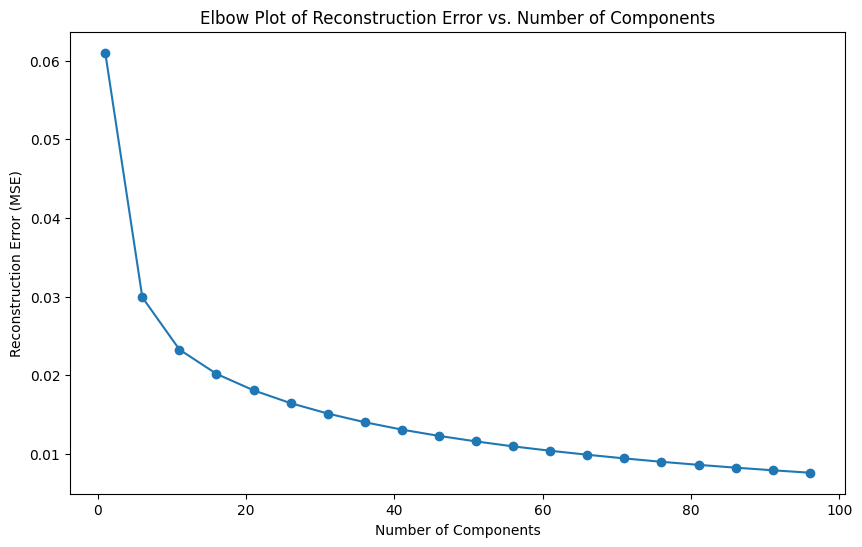

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Range of components to evaluate
components_range = range(1, 101, 5)  # Try 1, 6, 11, ..., up to 100
reconstruction_errors = []

for n_components in tqdm(components_range):
    # Initialize and fit PCA autoencoder
    pca_autoencoder = PcaAutoencoder(n_components)
    pca_autoencoder.fit(X_val)  # Using validation data to evaluate reconstruction error
    
    # Reconstruct the validation data
    X_val_reconstructed = pca_autoencoder.forward(X_val)
    
    # Calculate and store reconstruction error
    error = calculate_reconstruction_error(X_val, X_val_reconstructed)
    reconstruction_errors.append(error)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Elbow Plot of Reconstruction Error vs. Number of Components")
plt.show()


# around 32

power of 2

In [24]:
# convert to numpy
X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

Test MSE: 0.015245366232076505


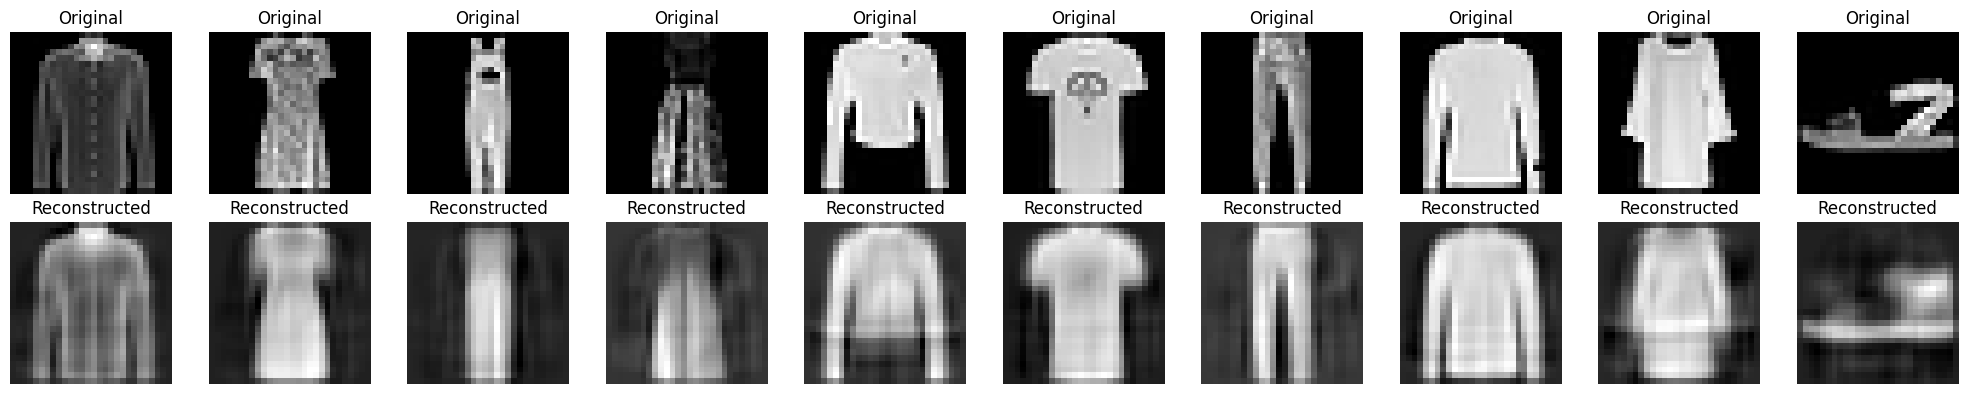

In [29]:
# Set koptimal based on the elbow plot
koptimal = 32  # Example value; replace with your actual optimal value from the plot

# Train the PCA Autoencoder with koptimal components
pca_autoencoder = PcaAutoencoder(koptimal)
pca_autoencoder.fit(X_train)  # Fit on the full training set

# Encode and reconstruct test data
X_test_reconstructed = pca_autoencoder.forward(X_test)

# Calculate the reconstruction error
test_error = calculate_reconstruction_error(X_test, X_test_reconstructed)
print("Test MSE:", test_error)

# Visualize original and reconstructed images
num_images = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(num_images):
    # Display original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Display reconstructed image
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()
